EXISTING FLOW

<class 'torch.Tensor'> torch.Size([1, 2, 512, 512])


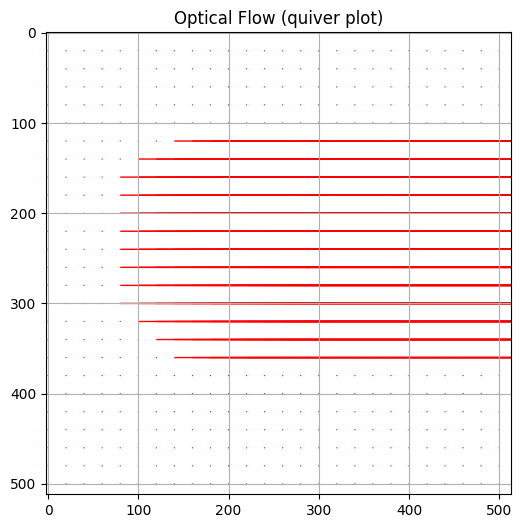

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load and remove batch dim
flow = torch.load('/work3/s204129/adlicv/project/VideoGeneration/assets/apple_old_flow/flows/flow_0.pth')
print(type(flow), flow.shape)  # Expecting (1, 2, H, W)
flow = flow.squeeze(0).permute(1, 2, 0).numpy()  # Now shape: (H, W, 2)

# Extract flow components
u = flow[:, :, 0]  # horizontal (dx)
v = flow[:, :, 1]  # vertical (dy)

# Subsample for visualization
step = 20
H, W = u.shape
y, x = np.mgrid[0:H:step, 0:W:step]

# Subsample vectors
u_sub = u[::step, ::step]
v_sub = v[::step, ::step]

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(np.ones((H, W, 3)))  # Optional white background
plt.quiver(x, y, u_sub, -v_sub, color='r', scale=100, width=0.003)
plt.title("Optical Flow (quiver plot)")
plt.axis("equal")
plt.grid(True)
plt.savefig("optical_flow_quiver.png", dpi=300)
plt.show()


COSTUM FLOW

<class 'torch.Tensor'> torch.Size([1, 2, 512, 512])


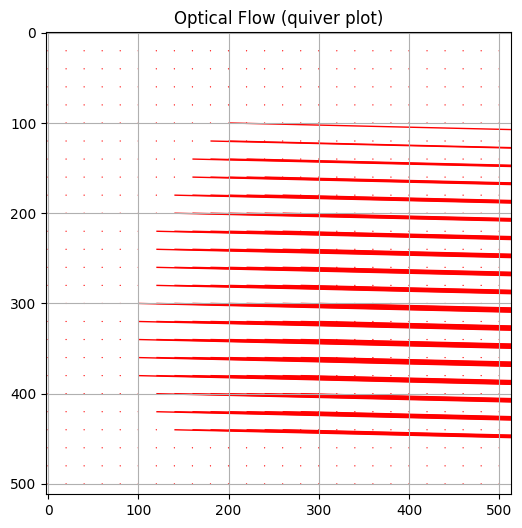

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load and remove batch dim
flow = torch.load('/work3/s204129/adlicv/project/VideoGeneration/assets/deluxe_topiary_3step_nolatents/flows/flow_1.pth')
print(type(flow), flow.shape)  # Expecting (1, 2, H, W)
flow = flow.squeeze(0).permute(1, 2, 0).numpy()  # Now shape: (H, W, 2)

# Extract flow components
u = flow[:, :, 0]  # horizontal (dx)
v = flow[:, :, 1]  # vertical (dy)

# Subsample for visualization
step = 20
H, W = u.shape
y, x = np.mgrid[0:H:step, 0:W:step]

# Subsample vectors
u_sub = u[::step, ::step]
v_sub = v[::step, ::step]

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(np.ones((H, W, 3)))  # Optional white background
plt.quiver(x, y, u_sub, -v_sub, color='r', scale=100, width=0.003)
plt.title("Optical Flow (quiver plot)")
plt.axis("equal")
plt.grid(True)
plt.savefig("optical_flow_quiver.png", dpi=300)
plt.show()


In [5]:
custom_flow = torch.load('/work3/s204129/adlicv/project/VideoGeneration/assets/apple_right_latents/flows/flow_2.pth')
print(type(custom_flow), custom_flow.shape)
# Load and squeeze batch dim
custom_flow = custom_flow.squeeze(0).numpy()  # shape: (2, 512, 512)


repo_flow = torch.load('/work3/s204129/adlicv/project/VideoGeneration/assets/apple_old_flow/flows/flow_0.pth')
print(type(repo_flow), repo_flow.shape)
repo_flow = repo_flow.squeeze(0).numpy()  # shape: (2, 512, 512)


print("Mean and std of custom flow")
print("Mean: ", np.mean(custom_flow))
print("Std: ", np.std(custom_flow))
print("Mean and std of repo flow")
print("Mean: ", np.mean(repo_flow))
print("Std: ", np.std(repo_flow))

<class 'torch.Tensor'> torch.Size([1, 2, 512, 512])
<class 'torch.Tensor'> torch.Size([1, 2, 512, 512])
Mean and std of custom flow
Mean:  12.618
Std:  40.560566
Mean and std of repo flow
Mean:  15.244961
Std:  45.324757


In [3]:
def make_colorwheel():
    """
    Generates a color wheel for optical flow visualization as presented in:
        Baker et al. "A Database and Evaluation Methodology for Optical Flow" (ICCV, 2007)
        URL: http://vision.middlebury.edu/flow/flowEval-iccv07.pdf

    Code follows the original C++ source code of Daniel Scharstein.
    Code follows the the Matlab source code of Deqing Sun.

    Returns:
        np.ndarray: Color wheel
    """

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR
    colorwheel = np.zeros((ncols, 3))
    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.arange(0,RY)/RY)
    col = col+RY
    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.arange(0,YG)/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG
    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.arange(0,GC)/GC)
    col = col+GC
    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.arange(CB)/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB
    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.arange(0,BM)/BM)
    col = col+BM
    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.arange(MR)/MR)
    colorwheel[col:col+MR, 0] = 255
    return colorwheel

def flow_uv_to_colors(u, v, convert_to_bgr=False):
    """
    Applies the flow color wheel to (possibly clipped) flow components u and v.

    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun

    Args:
        u (np.ndarray): Input horizontal flow of shape [H,W]
        v (np.ndarray): Input vertical flow of shape [H,W]
        convert_to_bgr (bool, optional): Convert output image to BGR. Defaults to False.

    Returns:
        np.ndarray: Flow visualization image of shape [H,W,3]
    """
    flow_image = np.zeros((u.shape[0], u.shape[1], 3), np.uint8)
    colorwheel = make_colorwheel()  # shape [55x3]
    ncols = colorwheel.shape[0]
    rad = np.sqrt(np.square(u) + np.square(v))
    a = np.arctan2(-v, -u)/np.pi
    fk = (a+1) / 2*(ncols-1)
    k0 = np.floor(fk).astype(np.int32)
    k1 = k0 + 1
    k1[k1 == ncols] = 0
    f = fk - k0
    for i in range(colorwheel.shape[1]):
        tmp = colorwheel[:,i]
        col0 = tmp[k0] / 255.0
        col1 = tmp[k1] / 255.0
        col = (1-f)*col0 + f*col1
        idx = (rad <= 1)
        col[idx]  = 1 - rad[idx] * (1-col[idx])
        col[~idx] = col[~idx] * 0.75   # out of range
        # Note the 2-i => BGR instead of RGB
        ch_idx = 2-i if convert_to_bgr else i
        flow_image[:,:,ch_idx] = np.floor(255 * col)
    return flow_image

def flow_to_image(flow_uv, clip_flow=None, convert_to_bgr=False, rad_max=None):
    """
    Expects a two dimensional flow image of shape.

    Args:
        flow_uv (np.ndarray): Flow UV image of shape [H,W,2]
        clip_flow (float, optional): Clip maximum of flow values. Defaults to None.
        convert_to_bgr (bool, optional): Convert output image to BGR. Defaults to False.

    Returns:
        np.ndarray: Flow visualization image of shape [H,W,3]
    """
    assert flow_uv.ndim == 3, 'input flow must have three dimensions'
    assert flow_uv.shape[2] == 2, 'input flow must have shape [H,W,2]'
    if clip_flow is not None:
        flow_uv = np.clip(flow_uv, 0, clip_flow)
    u = flow_uv[:,:,0]
    v = flow_uv[:,:,1]
    if rad_max is None:
        rad = np.sqrt(np.square(u) + np.square(v))
        rad_max = np.max(rad)
    epsilon = 1e-5
    u = u / (rad_max + epsilon)
    v = v / (rad_max + epsilon)
    return flow_uv_to_colors(u, v, convert_to_bgr)

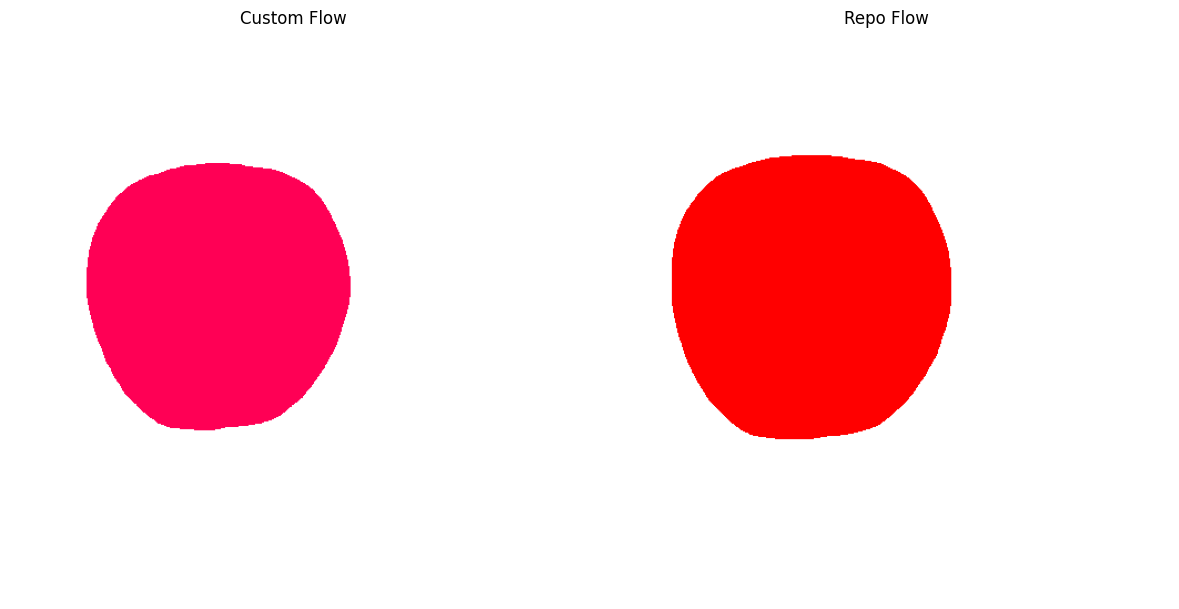

In [9]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load custom flow
custom_flow = torch.load('/work3/s204129/adlicv/project/VideoGeneration/assets/appledebug/flows/flow_1.pth')
vis_custom = flow_to_image(custom_flow[0].permute(1, 2, 0).cpu().numpy())
Image.fromarray(vis_custom).save("custom_flow.png")

# Load repo flow
repo_flow = torch.load('/work3/s204129/adlicv/project/VideoGeneration/assets/apple_old_flow/flows/flow_0.pth')
vis_repo = flow_to_image(repo_flow[0].permute(1, 2, 0).cpu().numpy())
Image.fromarray(vis_repo).save("repo_flow.png")

# Display both using matplotlib
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(vis_custom)
axs[0].set_title("Custom Flow")
axs[0].axis("off")

axs[1].imshow(vis_repo)
axs[1].set_title("Repo Flow")
axs[1].axis("off")


plt.tight_layout()
plt.savefig("flow_comparison.png", dpi=300)
plt.show()


# Exploring masks

### Existing mask

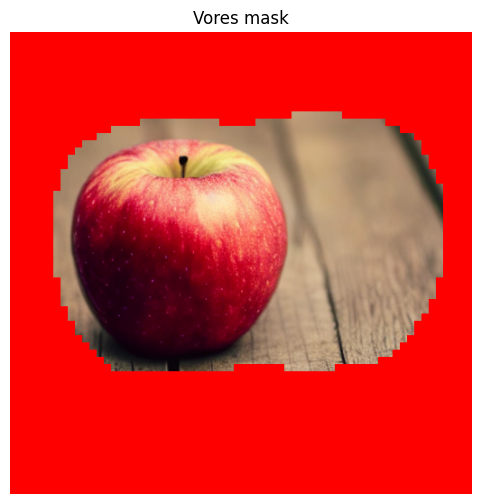

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- Load masks ---
mask = torch.load('/work3/s204129/adlicv/project/VideoGeneration/assets/deluxe_apple_3step_latents/masks/mask_1.pth')  # (1, 4, 64, 64)
mask = mask.numpy()[0][1]*1.  # (4, 64, 64)

# --- Load background image ---
background = np.array(Image.open('/work3/s204129/adlicv/project/VideoGeneration/assets/apple.png').resize((512, 512)).convert('RGB'))


# --- Visualize the saved mask for confirmation ---
upscaled_mask = np.array(Image.fromarray(mask * 255).resize((512, 512), Image.NEAREST))
vis_overlay = background.copy()
vis_overlay[upscaled_mask == 255] = [255, 0, 0]

plt.figure(figsize=(6, 6))
plt.imshow(vis_overlay)
plt.title("Vores mask")
plt.axis('off')
plt.show()


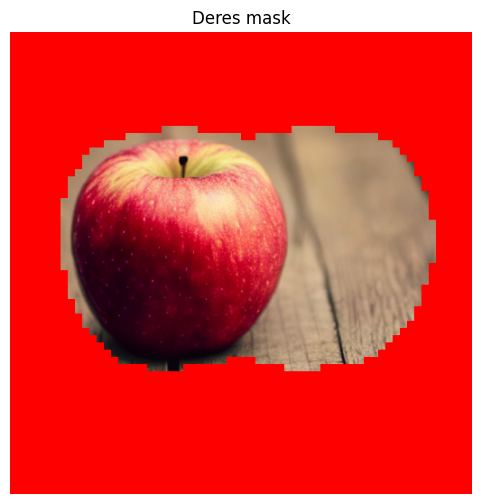

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- Load masks ---
mask = torch.load('/work3/s204129/adlicv/project/VideoGeneration/assets/apple_old_flow/masks/mask_0.pth')  # (1, 4, 64, 64)
mask = mask.numpy()[0][1]*1.  # (4, 64, 64)

# --- Load background image ---
background = np.array(Image.open('/work3/s204129/adlicv/project/VideoGeneration/assets/apple.png').resize((512, 512)).convert('RGB'))


# --- Visualize the saved mask for confirmation ---
upscaled_mask = np.array(Image.fromarray(mask * 255).resize((512, 512), Image.NEAREST))
vis_overlay = background.copy()
vis_overlay[upscaled_mask == 255] = [255, 0, 0]

plt.figure(figsize=(6, 6))
plt.imshow(vis_overlay)
plt.title("Deres mask")
plt.axis('off')
plt.show()


# What is that start.zt

In [10]:
start = torch.load('/work3/s204129/adlicv/project/VideoGeneration/data/topiary/start_zt.pth')
print(type(start), start.shape)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.